# AllLife Bank Customer Segmentation - Problem Statement

### Description

### Context

AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

 

### Objective

To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

 

### Data Description

The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).


### Data Dictionary

* Sl_No: Primary key of the records
* Customer Key: Customer identification number
* Average Credit Limit: Average credit limit of each customer for all credit cards
* Total credit cards: Total number of credit cards possessed by the customer
* Total visits bank: Total number of visits that customer made (yearly) personally to the bank
* Total visits online: Total number of visits or online logins made by the customer (yearly)
* Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

### Libraries

In [1]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import seaborn as sns

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.datasets import make_blobs


# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to compute distances
from scipy.spatial.distance import pdist

# to perform PCA
from sklearn.decomposition import PCA

# Pandas dataframe options
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth',400)


# set the background for the graphs
plt.style.use('ggplot')


# Printing style
from tabulate import tabulate

# Library to suppress warnings or deprecation notes 
import warnings
warnings.filterwarnings('ignore')

### Loading dataset

In [2]:
data = pd.read_excel('Credit+Card+Customer+Data.xlsx')

### Data Exploration 

* First five rows of the data
* Sample 10 rows 
* Shape of the data 
* Null values in the data  
* data type in each column of the data 
* duplicated data
* data describe

In [3]:
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [4]:
data.sample(10)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
606,607,31948,63000,5,3,1,3
360,361,15318,14000,6,3,0,1
155,156,35103,19000,1,1,4,5
102,103,26599,10000,4,1,5,10
236,237,56486,8000,7,5,2,3
618,619,54495,121000,7,0,13,2
497,498,41741,52000,4,2,1,2
584,585,35421,34000,6,4,1,3
120,121,16577,10000,4,2,4,6
420,421,48657,39000,5,3,2,2


In [5]:
print('There are {row} records, and {col} columns in the dataset'.format(row=data.shape[0], col=data.shape[1]))

There are 660 records, and 7 columns in the dataset


In [6]:
data.isnull().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [7]:
data.dtypes

Sl_No                  int64
Customer Key           int64
Avg_Credit_Limit       int64
Total_Credit_Cards     int64
Total_visits_bank      int64
Total_visits_online    int64
Total_calls_made       int64
dtype: object

In [8]:
data.duplicated().sum()

0

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.000,330.500,190.670,1.000,165.750,330.500,495.250,660.000
Customer Key,660.000,55141.444,25627.772,11265.000,33825.250,53874.500,77202.500,99843.000
Avg_Credit_Limit,660.000,34574.242,37625.488,3000.000,10000.000,18000.000,48000.000,200000.000
Total_Credit_Cards,660.000,4.706,2.168,1.000,3.000,5.000,6.000,10.000
Total_visits_bank,660.000,2.403,1.632,0.000,1.000,2.000,4.000,5.000
Total_visits_online,660.000,2.606,2.936,0.000,1.000,2.000,4.000,15.000
Total_calls_made,660.000,3.583,2.865,0.000,1.000,3.000,5.000,10.000


### Checking keys

In [10]:
data = data.set_index(['Sl_No'])

In [11]:
data.index.max()

660

In [12]:
data['Customer Key'].nunique()

655

* There is 5 duplicates in the customer key

### Analyzing the records with duplicate customer keys


In [13]:
data[data['Customer Key'].isin(data[data['Customer Key'].duplicated()]['Customer Key'].tolist())].sort_values('Customer Key')

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Sl_No,,,,,,
49,37252,6000,4,0,2,8
433,37252,59000,6,2,1,2
5,47437,100000,6,0,12,3
333,47437,17000,7,3,1,0
412,50706,44000,4,5,0,2
542,50706,60000,7,5,2,2
392,96929,13000,4,5,0,0
399,96929,67000,6,2,2,2
105,97935,17000,2,1,2,10


Records with the same Customer Key appear very differently from one another. Either the Customer Key assignment was incorrect, or the dataset does not contain the current version indicator. I'm going to treat these two people as separate customers for the time being. I will examine the groupings corresponding to these sets of records following the clustering.

### Standardizing Column Names

In [14]:
def feature_name_standardize(df: pd.DataFrame):
    df_ = df.copy()
    df_.columns = [i.replace(" ", "_").lower() for i in df_.columns]
    return df_

In [15]:
data = feature_name_standardize(data)


### Exploratory Data Analysis
#### Univariate Analysis

In [16]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

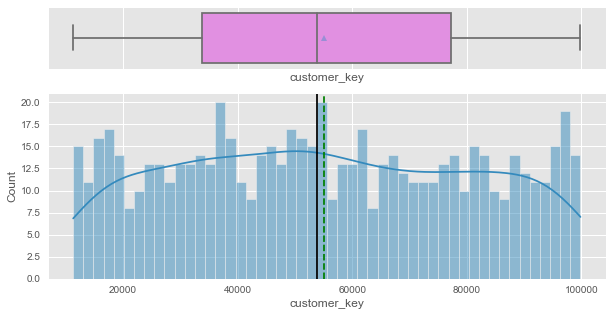

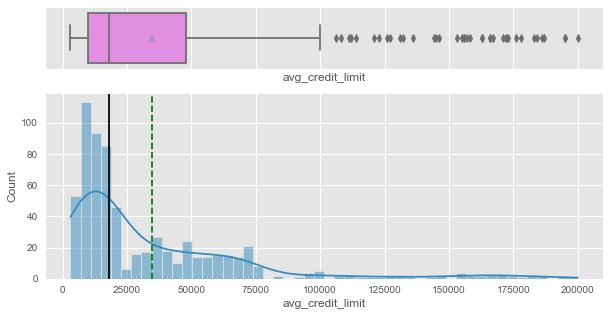

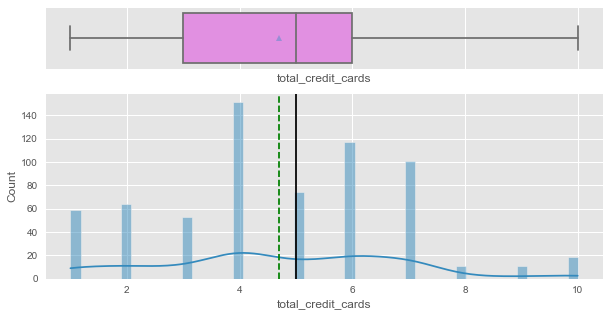

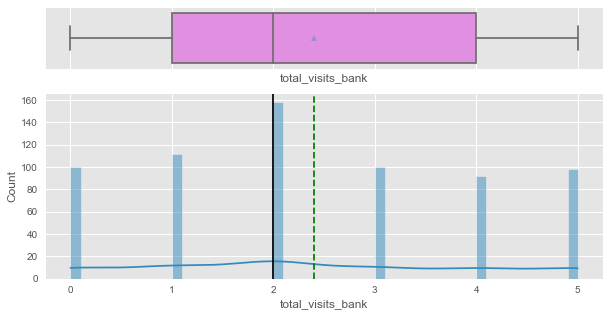

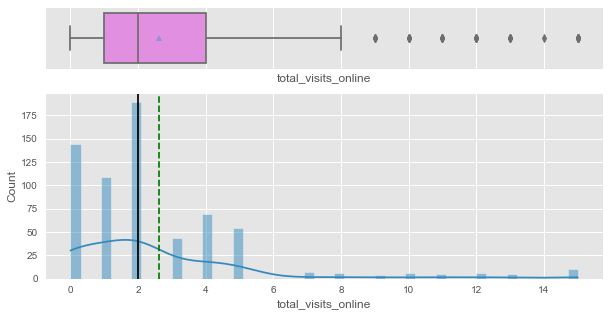

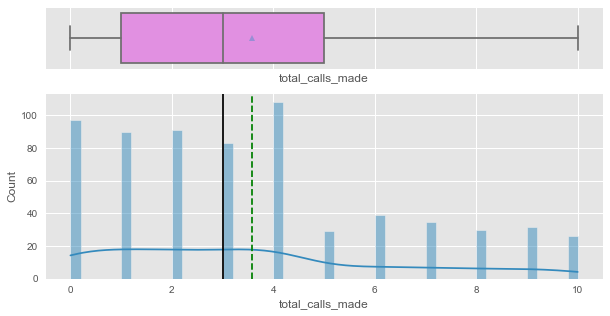

In [17]:
# selecting numerical columns
num_cols = data.select_dtypes(include=np.number).columns.tolist()

for item in num_cols:
    histogram_boxplot(data, item, bins=50, kde=True, figsize=(10, 5))

* Avg_Credit_Limit right skewed with a lot of outliers
* Total_Credit_Cards is fairly normally distributed with a few spikes	
* Total_visits_bank	is slightly right skewed
* Total_visits_online is right skewed and has some outliers to the right	
* Total_calls_made is right skewed

In [18]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [19]:
data['cc_spending_bin'] = pd.cut(data['avg_credit_limit'], bins=[3000,	10000,	18000, 	48000,	200000]
                                ,labels=['Very Low', 'Low', 'Mid', 'High'], include_lowest=True)

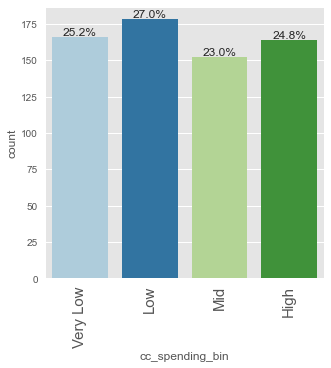

In [20]:
labeled_barplot(data, 'cc_spending_bin', perc=True)

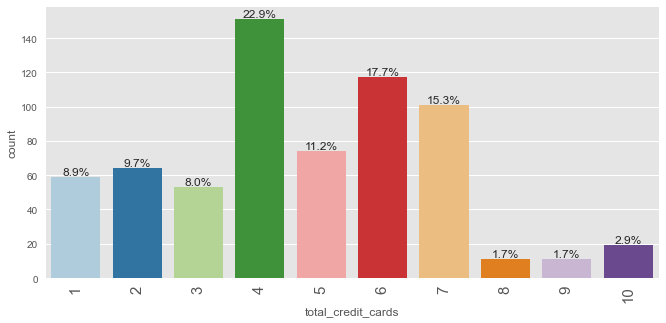

In [21]:
labeled_barplot(data, 'total_credit_cards', perc=True)

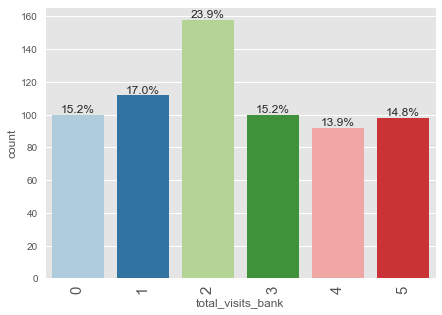

In [22]:
labeled_barplot(data, 'total_visits_bank', perc=True)

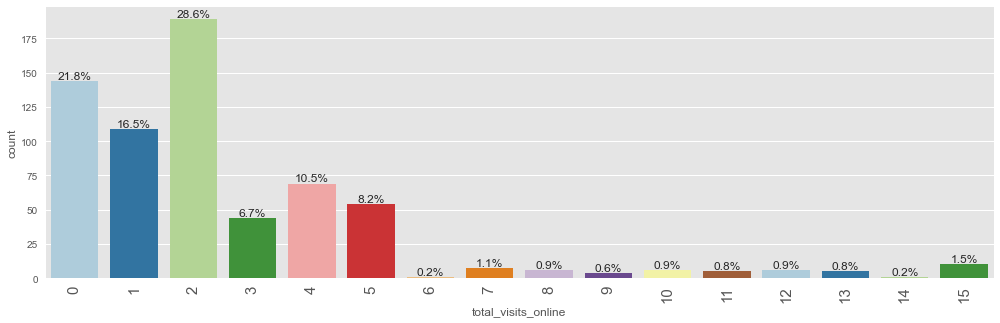

In [23]:
labeled_barplot(data, 'total_visits_online', perc=True)

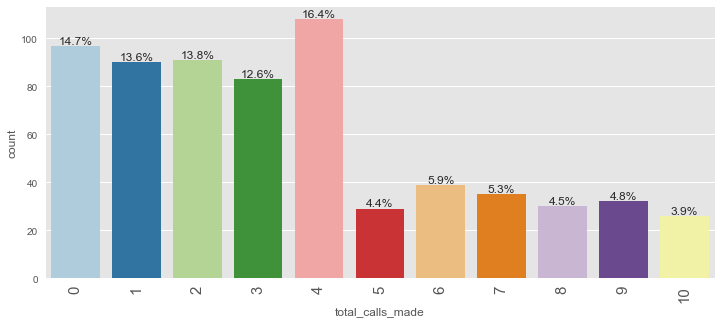

In [24]:
labeled_barplot(data, 'total_calls_made', perc=True)

### Bi-variate Analysis

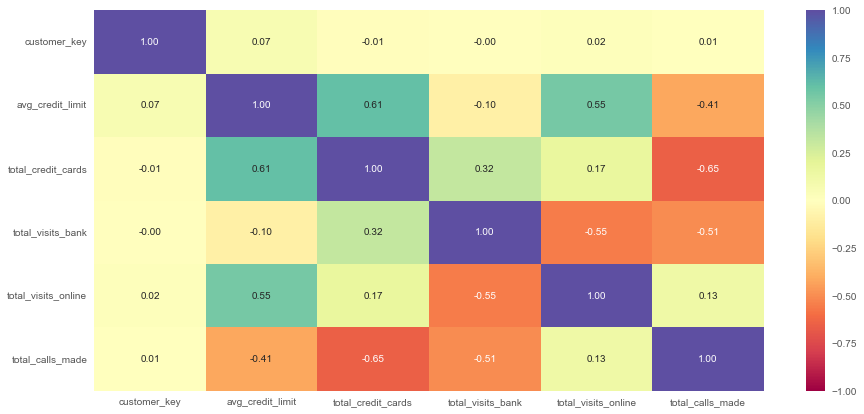

In [25]:
plt.figure(figsize=(15, 7))
sns.heatmap(
    data[num_cols].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

<Figure size 1440x1440 with 0 Axes>

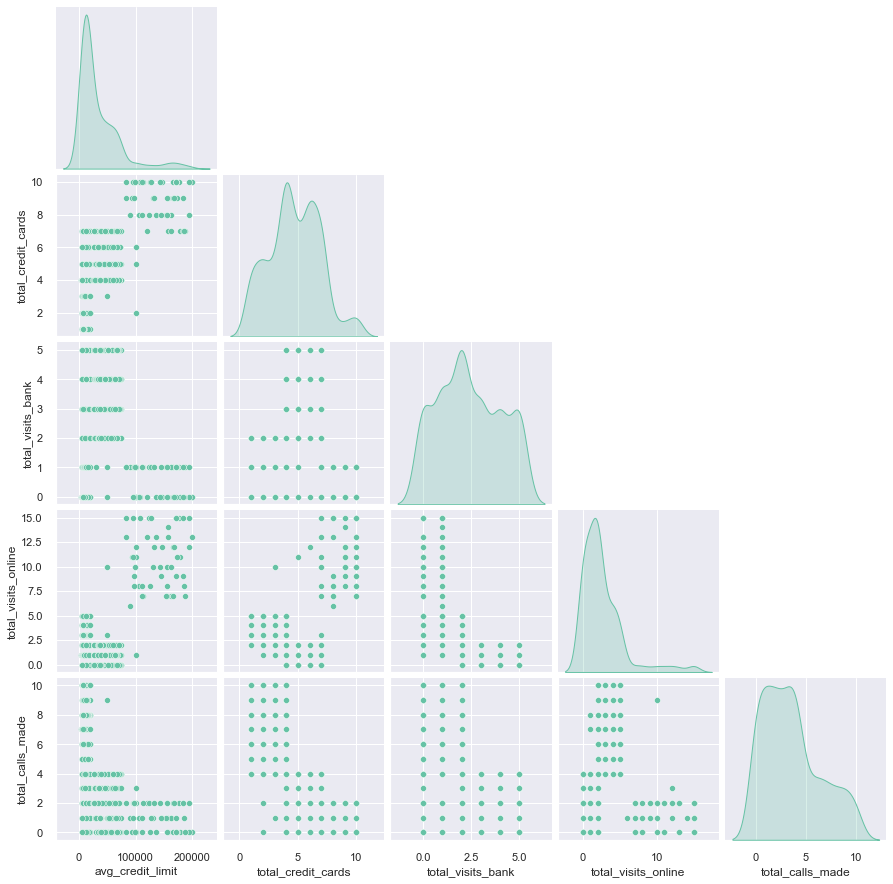

In [26]:
plt.figure(figsize=(20,20));
sns.set(palette="Set2");
sns.pairplot(data.iloc[:, 1:], diag_kind='kde', corner=True);

* Total Credit Cards and Total Calls Made are negatively correlated.
* Total Online Visits and Total Bank Visits have a negative correlation.
* Average Credit Limit has slightly positive correlation with Total Credit Cards (obviously) and Total Number of Visits Online, and slightly negative correlation with Total Calls Made

In [27]:
# Function to plot numerical feature by each category with target hue

def plot_numeric_by_cat(data: pd.DataFrame, category_columns: list, numeric_column: str, hue: str = None):
    '''
    The function plots a numerical feature in box plot by every category column specified in the list, 
    with hue of a target category
    '''
    num_cols = 2
    num_rows = int(len(category_columns) /2 + 1)

    plt.figure(figsize=(20, 8*num_rows))
    for i, col in enumerate(category_columns):
        plt.subplot(num_rows, num_cols, i+1)
        sns.set(palette="nipy_spectral");
        sns.boxplot(data=data, x=col, y=numeric_column, hue=hue, showfliers=True).set(title = numeric_column + ' vs. ' + col );

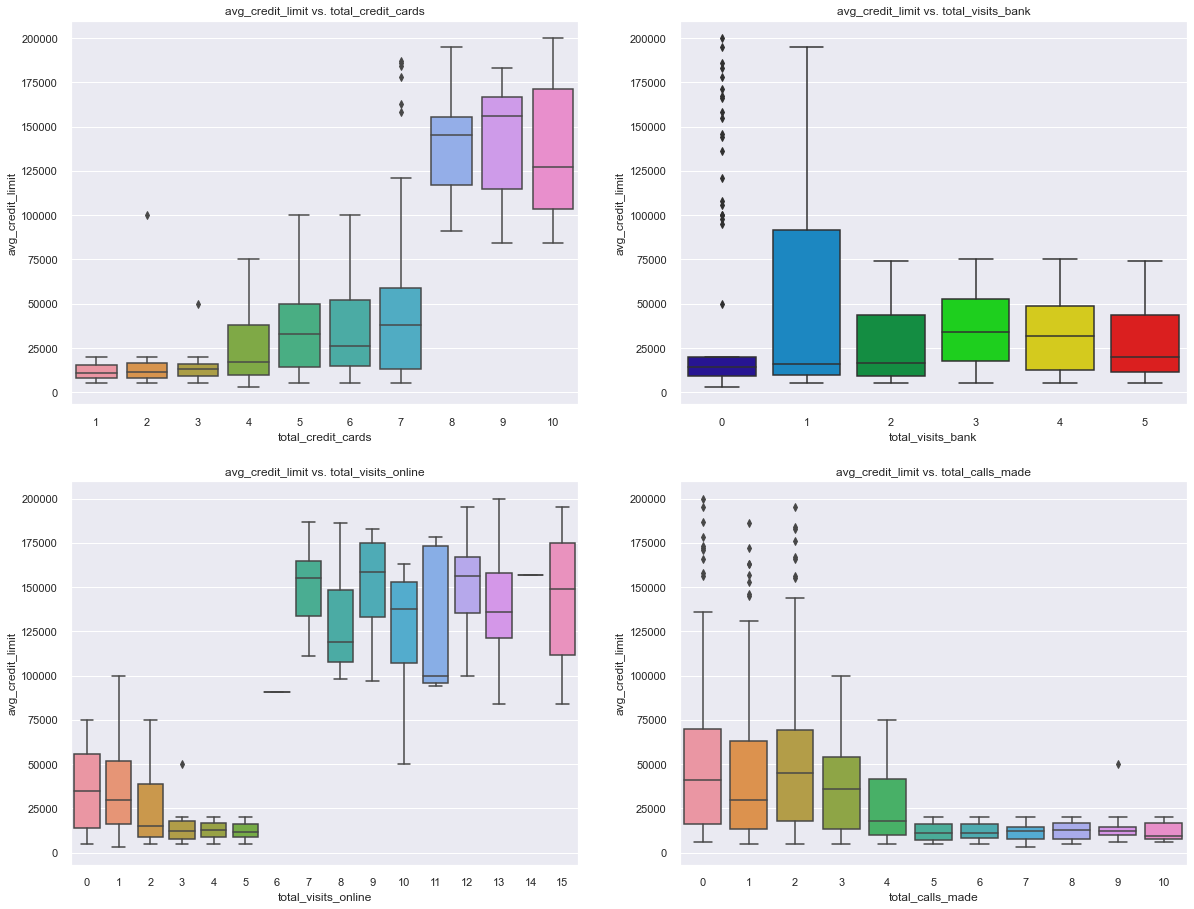

In [28]:
plot_numeric_by_cat(data\
                    ,category_columns=['total_credit_cards', 'total_visits_bank', 'total_visits_online', 'total_calls_made']\
                    ,numeric_column='avg_credit_limit')

### Data Pre-Processing 

In [29]:
# scaling the dataset before clustering
data_copy = data.copy()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.iloc[:,1:-1])

### K-means Clustering

#### Finding the best numbr of centroids (K)

Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.990778179643084
Number of Clusters: 6 	Average Distortion: 0.942907126541446
Number of Clusters: 7 	Average Distortion: 0.9093703386475
Number of Clusters: 8 	Average Distortion: 0.8900157986043848
Number of Clusters: 9 	Average Distortion: 0.8668507751238061


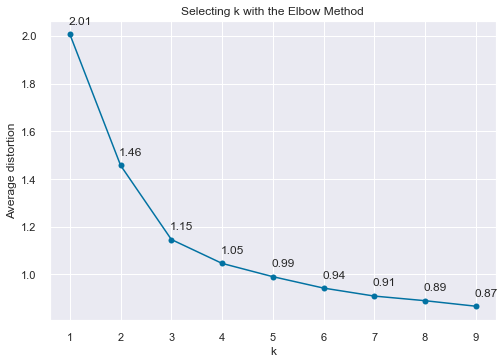

In [30]:
clusters = range(1, 10)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(data_scaled)
    prediction = model.predict(data_scaled)
    distortion = (
        sum(
            np.min(cdist(data_scaled, model.cluster_centers_, "euclidean"), axis=1)
        )
        / data_scaled.shape[0]
    )

    meanDistortions.append(distortion)
    
    print('Number of Clusters:', k, '\tAverage Distortion:', distortion)


plt.plot(clusters, meanDistortions, "bo-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
for x,y in zip(clusters, meanDistortions):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x + 0.2,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()

* Appropriate value for k seems to be 3

For n_clusters = 2, silhouette score is 0.41842496663215445)
For n_clusters = 3, silhouette score is 0.5157182558881063)
For n_clusters = 4, silhouette score is 0.3556670619372605)
For n_clusters = 5, silhouette score is 0.2717470361089752)
For n_clusters = 6, silhouette score is 0.2559585329098069)
For n_clusters = 7, silhouette score is 0.24821050966368377)
For n_clusters = 8, silhouette score is 0.2261295464258074)
For n_clusters = 9, silhouette score is 0.2123257429536718)


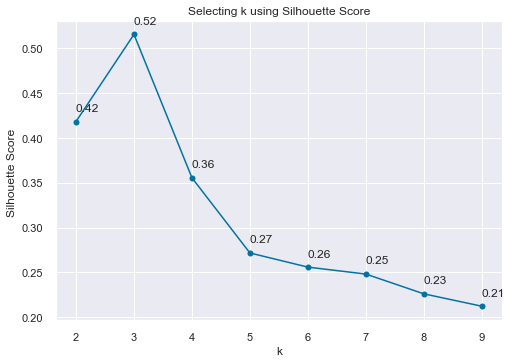

In [31]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((data_scaled))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(data_scaled, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    

plt.plot(cluster_list, sil_score, "bo-")
plt.xlabel("k")
plt.ylabel("Silhouette Score ")
plt.title("Selecting k using Silhouette Score")
for x,y in zip(cluster_list, sil_score):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x + 0.2,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()

* Silhouette score for 3 clusters is highest

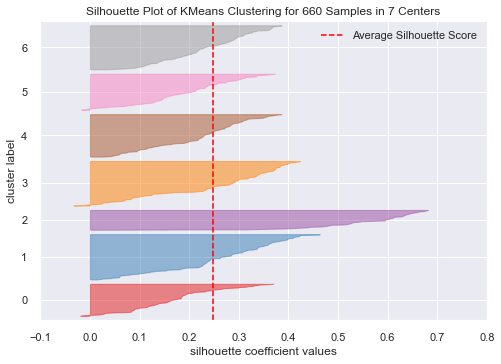

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [32]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(7, random_state=1))
visualizer.fit(data_scaled)
visualizer.show()

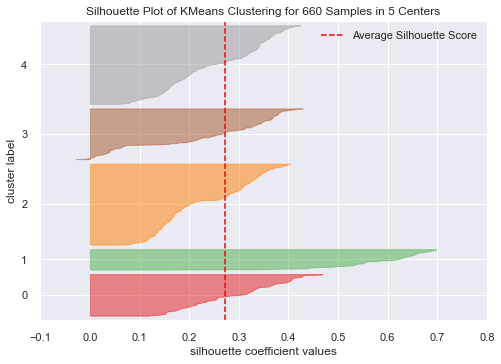

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [33]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(data_scaled)
visualizer.show()

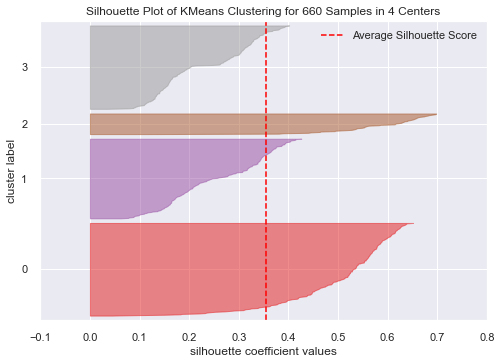

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [34]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(data_scaled)
visualizer.show()

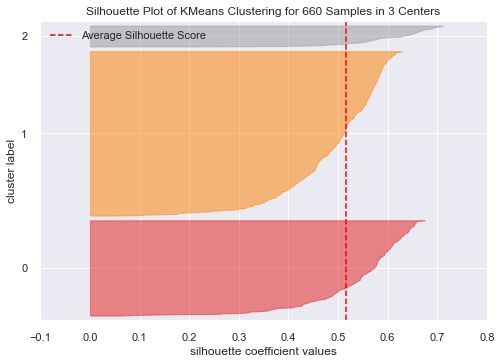

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [35]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(data_scaled)
visualizer.show()

In [36]:
# let's take 3 as number of clusters
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(data_scaled)

KMeans(n_clusters=3, random_state=0)

In [37]:
# adding kmeans cluster labels to the original and scaled dataframes
data_scaled_df = pd.DataFrame(data_scaled, columns=data.iloc[:,1:-1].columns.unique().tolist())

In [38]:
data['K_means_segments'] = kmeans.labels_

In [39]:
cluster_profile = data.groupby('K_means_segments').mean()

In [40]:
cluster_profile['count_in_each_segment'] = ( data.groupby('K_means_segments')['customer_key'].count().values )

In [41]:
cluster_profile

,customer_key,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made,count_in_each_segment
K_means_segments,,,,,,,
0,54881.329,33782.383,5.516,3.490,0.982,2.000,386
1,55239.830,12174.107,2.411,0.933,3.554,6.871,224
2,56708.760,141040.000,8.740,0.600,10.900,1.080,50


<AxesSubplot:xlabel='K_means_segments'>

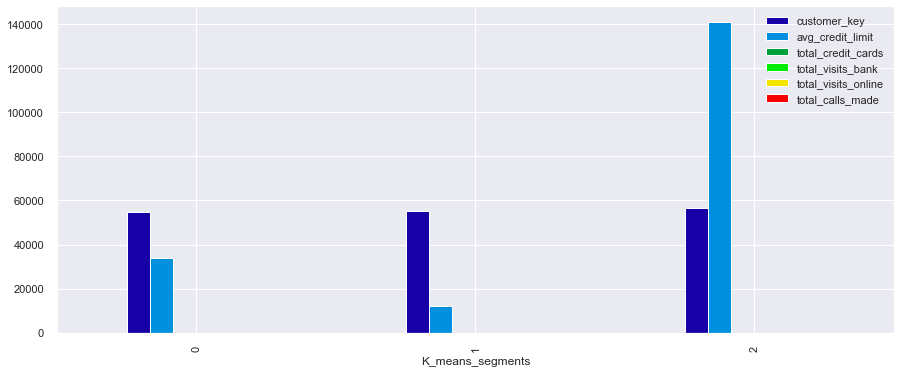

In [42]:
data.groupby("K_means_segments").mean().plot.bar(figsize=(15, 6))

In [43]:
all_col = data.iloc[:,1:].columns.tolist()

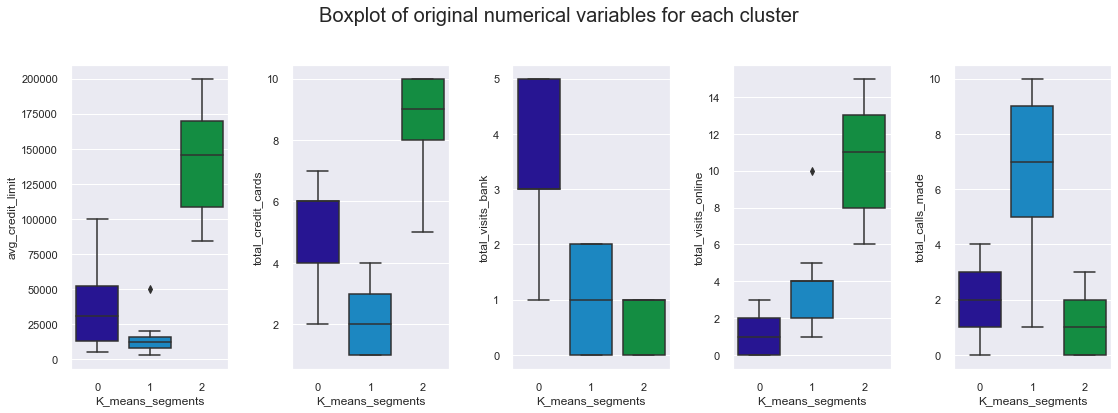

In [44]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=data[all_col[counter]], x=data["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

## Insights

#### Cluster 0:

* Customers that prefer in-person interactions typically have credit cards and credit limits in the middle
* The average credit limit for this cluster is under $25,000.
* There are often between 1 and 3 credit cards in use.
* In this cluster, we can only see a maximum of 2 trips overall to the bank.
* In this cluster, we can only see a maximum of 4 total online visits.
* In this cluster, there have been a minimum of 5 calls and a maximum of about 9 calls.

#### Cluster 1:

* The clients who contact via phonecall are in another sector, who have lowest credit limit and number of cards
* The average credit limit for this cluster ranges from $25,000 to more than 50,000 but less than 75,000.
* The maximum number of credit cards allowed in this cluster is 5.
* In this cluster, there have been a total of two to three trips to the bank.
* In this cluster, we can only detect a maximum of 2 trips made entirely online.
* In this cluster, there were a total of 1 to 3 calls made.

#### Cluster 2:

* If we examine the data, we can see that there is a group that enjoys using their bank's website for transactions. This group also has more credit cards and a much larger credit limit
* The average credit limit limits in this cluster are greater than $100,000 to $175,000.
* There are generally 8 to 10 credit cards in use overall.
* There has only been a single visit to the bank overall.
* The range of total online visits in this cluster is between 8 and 13.
* The total number of calls made in this cluster ranges from 0 at the minimum to about 2.

### What is Cophenetic correlation? 

The cophenetic correlation coefficient is a correlation coefficient between the cophenetic distances(Dendrogramic distance) obtained from the tree, and the original distances used to construct the tree. It is a measure of how faithfully a dendrogram preserves the pairwise distances between the original unmodeled data points. 

The cophenetic distance between two observations is represented in a dendrogram by the height of the link at which those two observations are first joined. That height is the distance between the two subclusters that are merged by that link.

Cophenetic correlation is the way to compare two or more dendrograms. 

In [45]:
# cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
# closer it is to 1, the better is the clustering
distance_metrics = [ 'euclidean','chebyshev','mahalanobis','cityblock']
linkage_methods = ['single', 'complete', 'average', 'weighted']
high_cophenet_corr = 0
high_dm_lm = [0,0]
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(data_scaled, metric=dm, method=lm)
        c, coph_dists = cophenet(Z , pdist(data_scaled))
        print('Cophent correlation for distance metrics {} and linkahe method {} is {}'.format(dm,lm,c))
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophent correlation for distance metrics euclidean and linkahe method single is 0.7391220243806552
Cophent correlation for distance metrics euclidean and linkahe method complete is 0.8599730607972423
Cophent correlation for distance metrics euclidean and linkahe method average is 0.8977080867389372
Cophent correlation for distance metrics euclidean and linkahe method weighted is 0.8861746814895477
Cophent correlation for distance metrics chebyshev and linkahe method single is 0.7382354769296767
Cophent correlation for distance metrics chebyshev and linkahe method complete is 0.8533474836336782
Cophent correlation for distance metrics chebyshev and linkahe method average is 0.8974159511838106
Cophent correlation for distance metrics chebyshev and linkahe method weighted is 0.8913624010768603
Cophent correlation for distance metrics mahalanobis and linkahe method single is 0.7058064784553606
Cophent correlation for distance metrics mahalanobis and linkahe method complete is 0.54227912098

In [46]:
print('Highest cophenet correlation is {}, which is obtinaed with {} distance metric and {} linkage method'.format(high_cophenet_corr ,high_dm_lm[0],high_dm_lm[1]))

Highest cophenet correlation is 0.8977080867389372, which is obtinaed with euclidean distance metric and average linkage method


In [47]:
linkage_methods = ['single', 'complete', 'average','median','ward', 'weighted']
high_cophenet_corr = 0
high_dm_lm = [0,0]

for lm in linkage_methods:
    Z = linkage(data_scaled, metric='euclidean', method=lm)
    c, coph_dists = cophenet(Z , pdist(data_scaled))
    print('Cophent correlation for distance metrics {} and linkahe method {} is {}'.format('euclidean',lm,c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = dm
        high_dm_lm[1] = lm

Cophent correlation for distance metrics euclidean and linkahe method single is 0.7391220243806552
Cophent correlation for distance metrics euclidean and linkahe method complete is 0.8599730607972423
Cophent correlation for distance metrics euclidean and linkahe method average is 0.8977080867389372
Cophent correlation for distance metrics euclidean and linkahe method median is 0.8893799537016724
Cophent correlation for distance metrics euclidean and linkahe method ward is 0.7415156284827493
Cophent correlation for distance metrics euclidean and linkahe method weighted is 0.8861746814895477


In [48]:
print('Highest cophenet correlation is {}, which is obtinaed with {} distance metric and {} linkage method'.format(high_cophenet_corr ,high_dm_lm[0],high_dm_lm[1]))

Highest cophenet correlation is 0.8977080867389372, which is obtinaed with cityblock distance metric and average linkage method


### Hierarchical Clustering

In [49]:
# list of distance metrics
distance_metrics = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation',
        'cosine', 'euclidean', 'hamming', 'jaccard', 'mahalanobis', 'matching', 'minkowski', 'seuclidean',  'sqeuclidean']

# list of linkage methods
linkage_methods = ['complete', 'average', 'single', 'weighted']

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(data_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(data_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Braycurtis distance and complete linkage is 0.5082233975395475.
Cophenetic correlation for Braycurtis distance and average linkage is 0.6052152783444972.
Cophenetic correlation for Braycurtis distance and single linkage is 0.8502845518924395.
Cophenetic correlation for Braycurtis distance and weighted linkage is 0.531818336516011.
Cophenetic correlation for Canberra distance and complete linkage is 0.46069443891594597.
Cophenetic correlation for Canberra distance and average linkage is 0.6751521558776901.
Cophenetic correlation for Canberra distance and single linkage is 0.7566178713003985.
Cophenetic correlation for Canberra distance and weighted linkage is 0.5351232761249246.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlat

In [50]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389373, which is obtained with average linkage.


### Dendograms

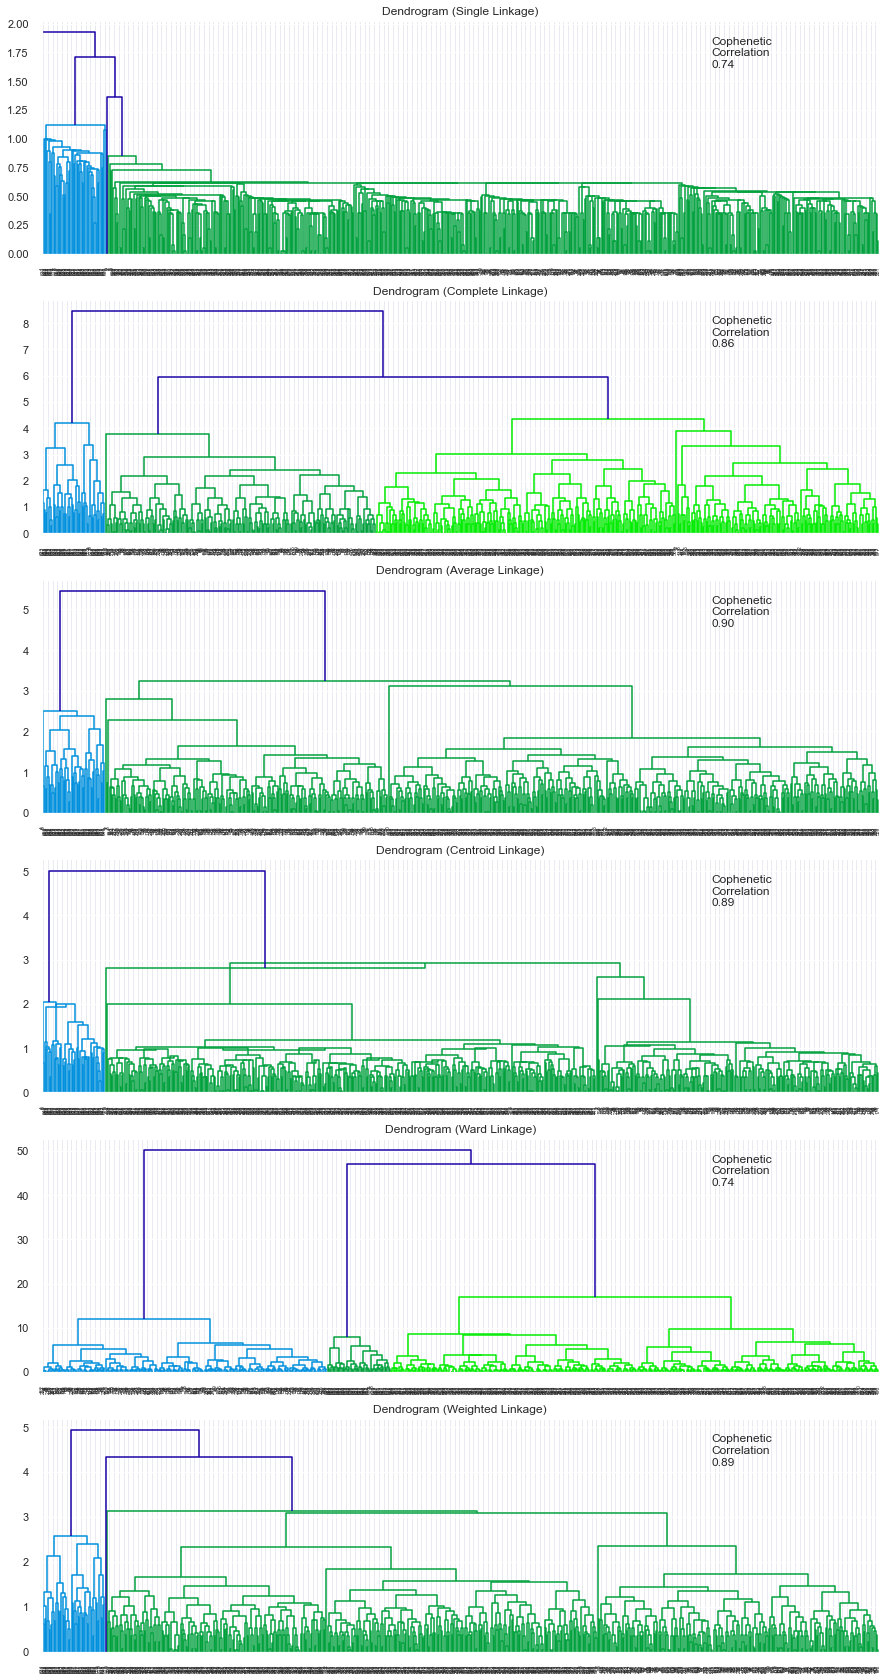

In [51]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(data_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(data_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction")
    compare.append([method, coph_corr])

In [52]:
# Create and print dataframe to compare Cophenetic Coefficient for each linkage
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc

,Linkage,Cophenetic Coefficient
0,single,0.739
1,complete,0.860
2,average,0.898
3,centroid,0.894
4,ward,0.742
5,weighted,0.886


### Let's see the dendrogram for Mahalanobis and Manhattan distances with average and weighted linkage methods (as they gave high cophenetic correlation values).

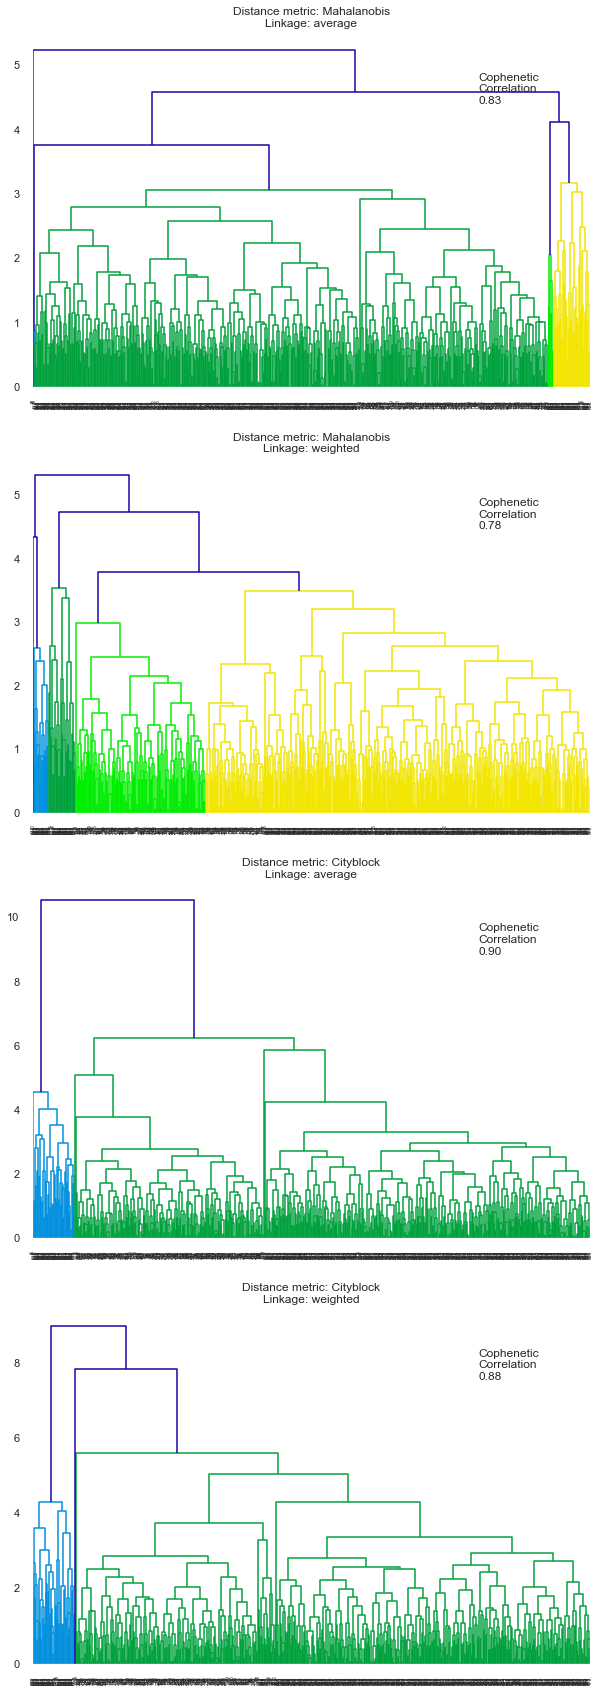

In [53]:
# list of distance metrics
distance_metrics = ["mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["average", "weighted"]

# to create a subplot image
fig, axs = plt.subplots(
    len(distance_metrics) + len(distance_metrics), 1, figsize=(10, 30)
)

i = 0
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(data_scaled_df, metric=dm, method=lm)

        dendrogram(Z, ax=axs[i])
        axs[i].set_title("Distance metric: {}\nLinkage: {}".format(dm.capitalize(), lm))

        coph_corr, coph_dist = cophenet(Z, pdist(data_scaled_df))
        axs[i].annotate(
            f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
            (0.80, 0.80),
            xycoords="axes fraction",
        )
        i += 1

In [77]:
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="ward")
HCmodel.fit(data_scaled_df)

AgglomerativeClustering(n_clusters=3)

In [78]:
# adding hierarchical cluster labels to the original and scaled dataframes
data_scaled_df["HC_Clusters"] = HCmodel.labels_
data["HC_Clusters"] = HCmodel.labels_

In [79]:
cluster_profile = data.groupby('HC_Clusters').mean()

In [80]:
cluster_profile['count_in_each_segments'] = data.groupby('HC_Clusters')['avg_credit_limit'].count().values

In [81]:
# lets display cluster profile
cluster_profile

,customer_key,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made,K_means_segments,count_in_each_segments
HC_Clusters,,,,,,,,
0,54895.745,33851.948,5.517,3.494,0.979,1.995,0.000,385
1,55213.569,12151.111,2.422,0.938,3.547,6.858,0.996,225
2,56708.760,141040.000,8.740,0.600,10.900,1.080,2.000,50


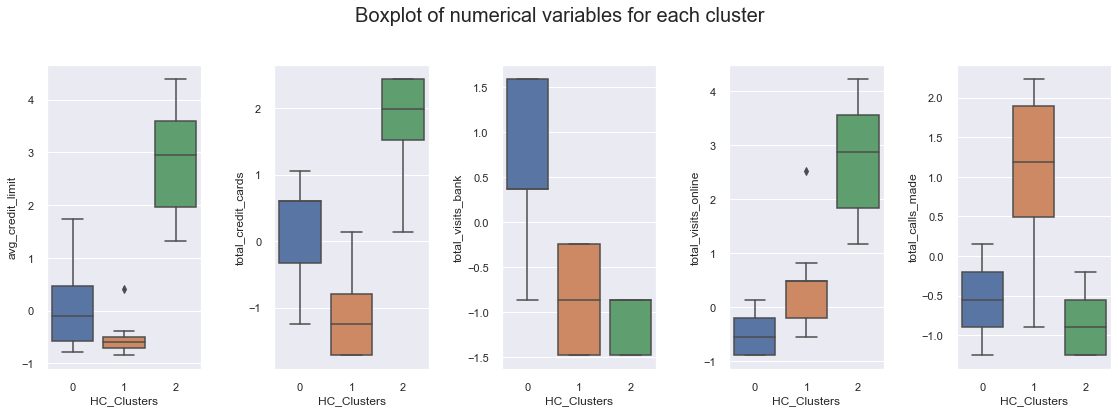

In [82]:
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster', fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],y=data_scaled_df[all_col[counter]],x=data_scaled_df['HC_Clusters'])
    counter = counter+1

fig.tight_layout(pad=2.0)

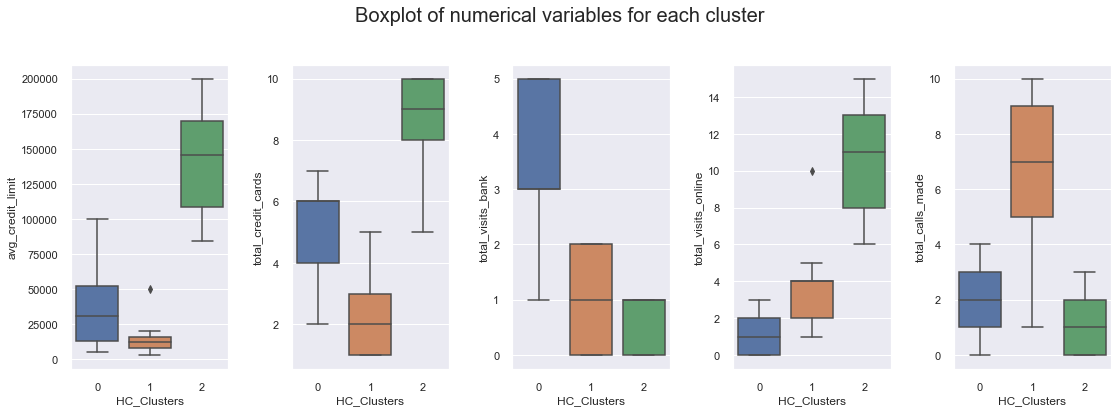

In [83]:
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster', fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],y=data[all_col[counter]],x=data['HC_Clusters'])
    counter = counter+1

fig.tight_layout(pad=2.0)

## Insights

#### Cluster 0:

* Customers that prefer in-person interactions typically have credit cards and credit limits in the middle
* The average credit limit for this cluster is under $25000
* There are often between 1 and 3 credit cards in use.
* In this cluster, we can only see a maximum of 2 trips overall to the bank.
* In this cluster, we can only see a maximum of 4 total online visits.
* In this cluster, there have been a minimum of 5 calls and a maximum of about 9 calls.

#### Cluster 1:

* If we examine the data, we can see that there is a group that enjoys using their bank's website for transactions. This group also has more credit cards and a much larger credit limit
* The average credit limit for this cluster ranges from $25,000 to more than 50,000 but less than 75,000.
* The maximum number of credit cards allowed in this cluster is 5.
* In this cluster, there have been a total of two to three trips to the bank.
* In this cluster, we can only detect a maximum of 2 trips made entirely online.
* In this cluster, there were a total of 1 to 3 calls made.

#### Cluster 2:
* Customers who contact by phone belong to a different category and have the fewest credit limits and cards
* The average credit limit limits in this cluster are greater than $100,000 to $175,000.
* There are generally 8 to 10 credit cards in use overall.
* There has only been a single visit to the bank overall.
* The range of total online visits in this cluster is between 8 and 13.
* The total number of calls made in this cluster ranges from 0 at the minimum to about 2.

### Cluster Profiling

### PCA for Dimensionality Reduction

In [84]:
data_scaled_df_pca = data_scaled_df.drop('HC_Clusters', axis=1).copy()

In [85]:
pca = PCA()
pca.fit(data_scaled_df_pca)

PCA()

In [86]:
pca.explained_variance_ratio_

array([0.45736578, 0.37426483, 0.06401348, 0.0555688 , 0.04878711])

Text(0, 0.5, 'Cumulative Explained Variance')

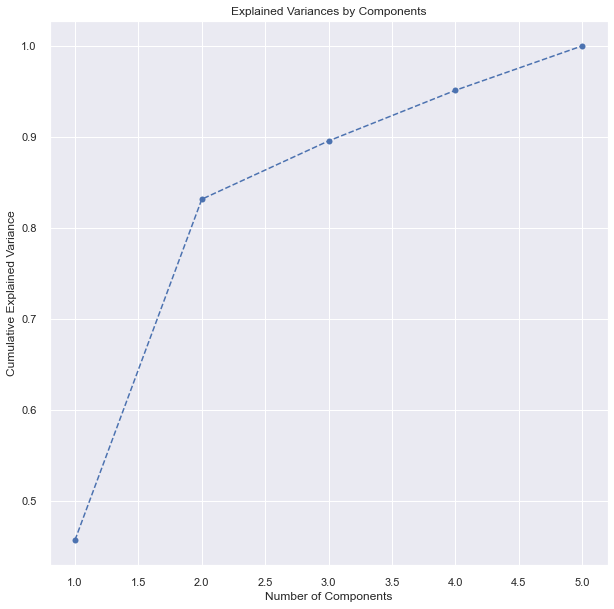

In [87]:
# visualizing the variance explained by individual principal components
sns.set(style='darkgrid')
plt.figure(figsize=(10, 10))
plt.plot(
    range(1, 6), pca.explained_variance_ratio_.cumsum(), marker="o", linestyle="--"
)
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

In [88]:
pca = PCA(
    n_components=3, svd_solver="full"
)  # svd_solver=full helps in faster convergence in case of very large data set
pca.fit(data_scaled_df_pca)

PCA(n_components=3, svd_solver='full')

In [89]:
# checking the variance explained by individual components.
print('Explained variance = {var} %'.format(var=round(pca.explained_variance_ratio_.sum(),2)*100))

Explained variance = 90.0 %


Text(0, 0.5, 'Cumulative Explained Variance')

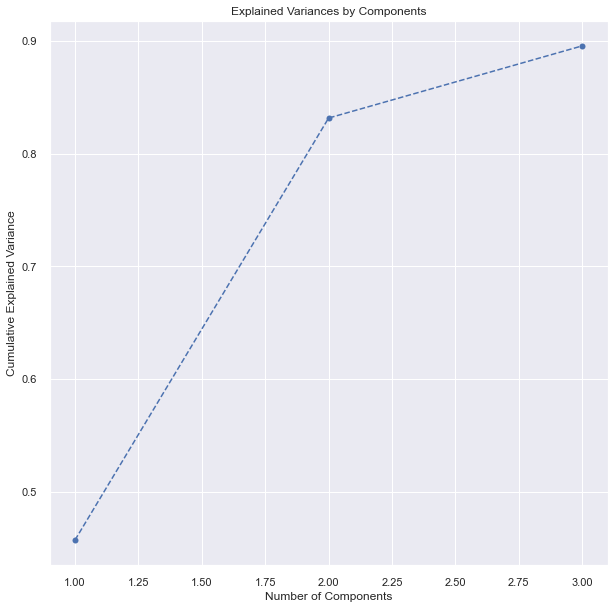

In [90]:
plt.figure(figsize=(10, 10))
plt.plot(
    range(1, 4), pca.explained_variance_ratio_.cumsum(), marker="o", linestyle="--"
)
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

In [91]:
subset_pca = pca.transform(data_scaled_df_pca)
subset_pca_df = pd.DataFrame(subset_pca)

### Hierarchical Clustering on lower-dimensional data

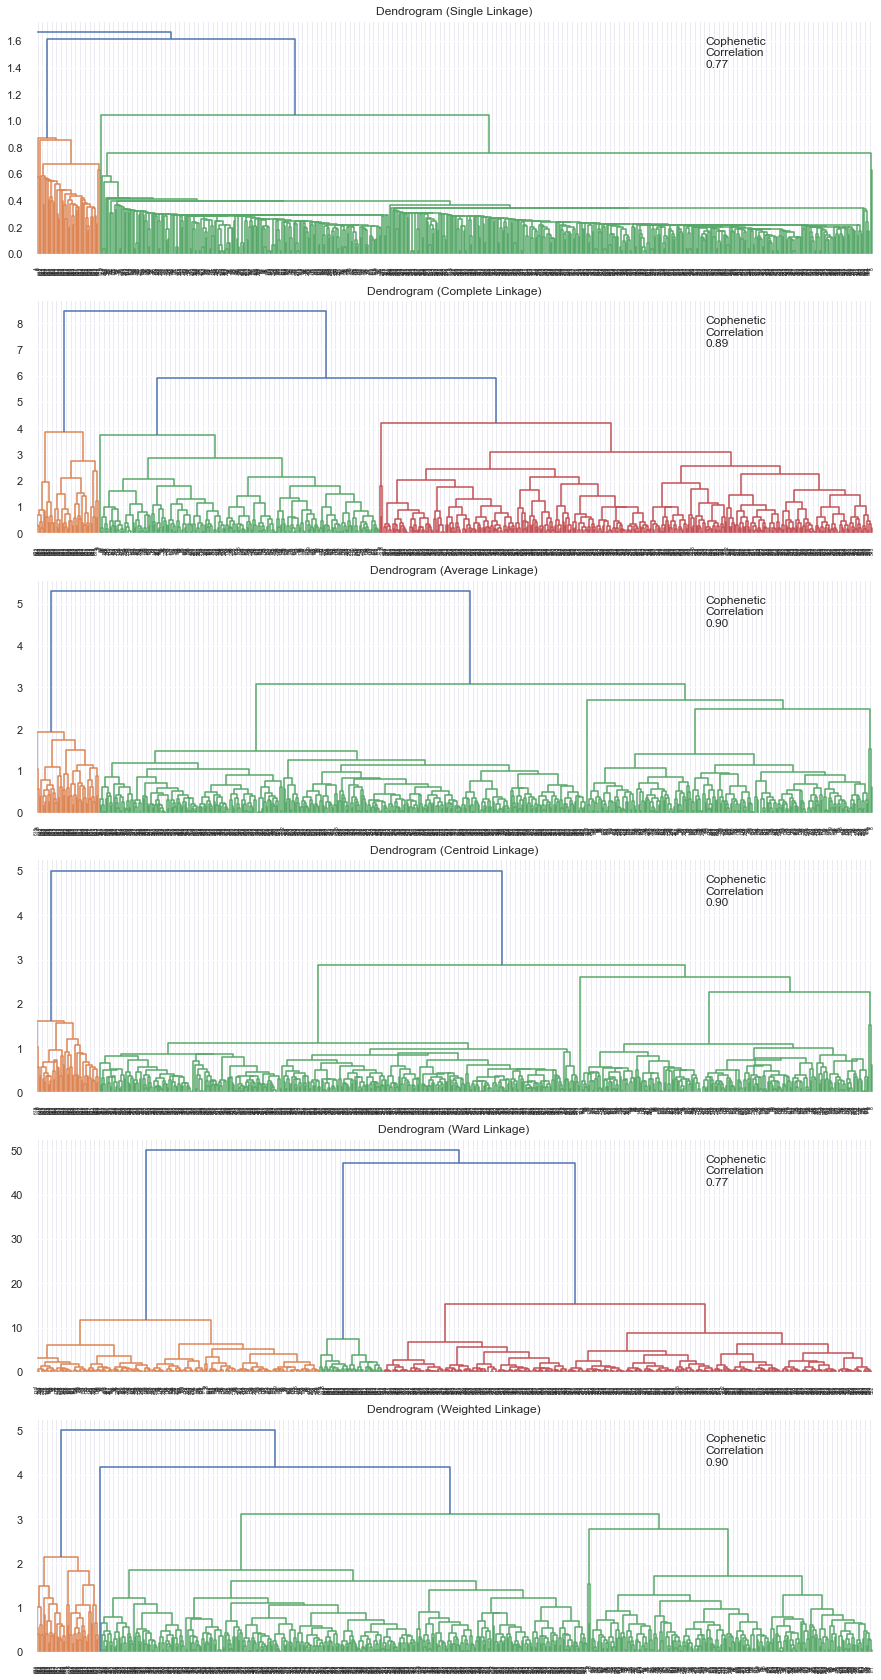

In [92]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_pca_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_pca_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

In [93]:
hc = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="complete")
hc_labels = hc.fit_predict(subset_pca)

In [94]:
# adding hierarchical cluster labels to the original dataframe
data_pca = data.drop(['K_means_segments', 'HC_Clusters'], axis=1)
data_pca['pca_hc_cluster'] = hc_labels

In [95]:
data_scaled_pca_df = data_scaled_df.drop('HC_Clusters', axis=1)
data_scaled_pca_df['pca_hc_cluster'] = hc_labels

In [96]:
cluster_profile2 = data_pca.groupby('pca_hc_cluster').mean()
cluster_profile2['customer_count'] = (
    data_pca.groupby('pca_hc_cluster')['customer_key'].count().values
)

In [97]:
# let's display cluster profile
cluster_profile2

,customer_key,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made,customer_count
pca_hc_cluster,,,,,,,
0,54951.710,33591.260,5.496,3.468,0.987,2.003,389
1,56708.760,141040.000,8.740,0.600,10.900,1.080,50
2,55120.814,12217.195,2.403,0.937,3.579,6.932,221


In [98]:
pca_df = subset_pca_df.copy()
pca_df['pca_hc_cluster'] = hc_labels

pca_df = pca_df.rename(columns={0:'component_1', 1:'component_2', 2:'component_3'})

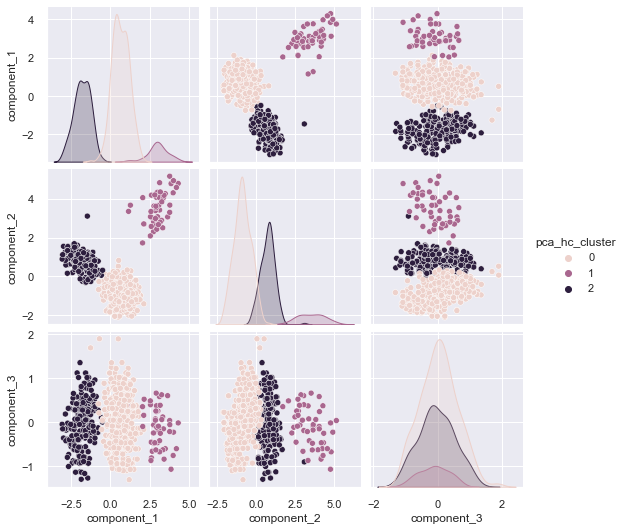

In [99]:
sns.pairplot(pca_df, diag_kind='kde', hue='pca_hc_cluster');

### Actionable insights and Recommendations

There seem to be three different types of clients:

1. Users who conduct their banking activities in person. They have an average number of credit cards and credit limits. They are also the users who are most active.

2. Phone users prefer to conduct transactions verbally. Their credit card limit is the lowest and they have the fewest cards.

3. Online shoppers favor electronic transactions. Additionally, they have the most credit cards and the biggest credit lines available. The smallest percentage of customers engage in this behavior.

Contacting the customers should be done using their preferences. Online and mobile users are likely to favor email and text alerts, while in-person users favor mail alerts and upselling (when at the bank location).